In [88]:
import numpy as np
from numpy import average
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [89]:
exel_data = pd.read_excel("data/cources2021.xlsx")

df = exel_data.drop(labels=[0], axis = 0)

for i in range(2, len(df.columns), 2):
  index = len(df.columns[i-1])-1
  newName = df.columns[i-1][index-3:index]
  oldName = df.columns[i]
  df.rename(columns={oldName : newName}, inplace = True)

course_df = df[['Дата', 'USD', 'EUR']]

course_df.head()

,Дата,USD,EUR
1,2021-01-01,2.5789,3.168
2,2021-01-02,2.5789,3.168
3,2021-01-03,2.5789,3.168
4,2021-01-04,2.5789,3.168
5,2021-01-05,2.5795,3.1644


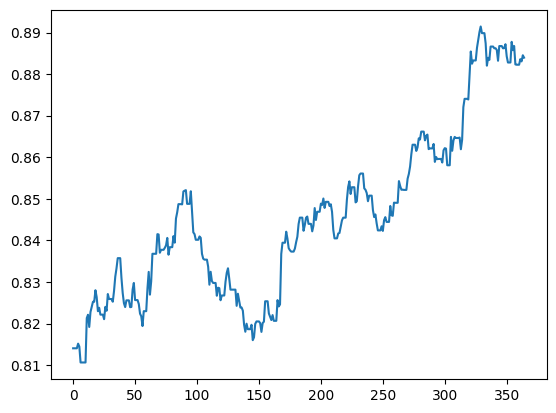

In [90]:
y = np.array(course_df['USD']/course_df['EUR'])
x = np.arange(y.size)

y = y.reshape((-1,1))
x = x.reshape((-1,1))
plt.plot(x, y)


In [91]:
def slidingWindow(y, windowSize, predCount):
    y_rez = np.array(y.copy())
    for i in  range(predCount):
        m = np.average(y_rez[len(y_rez) - windowSize-1 : len(y_rez)-1])
        y_rez = np.append(y_rez, m + 1/windowSize * (y_rez[len(y_rez)-1] - y_rez[len(y_rez)-2]))

    return y_rez

In [92]:
def sigmoid(x):
    #Сигмоидная функция активации: f(x) = 1 / (1 + e^(-x))
    return 1 / (1 + np.exp(-x))
    #return 1 if x > 0 else 0

def dersigmoid(s):
  return sigmoid(s) * (1 - sigmoid(s))

def Hebb(weight, ny, x0, y, e):
    return weight - ny * x0 * (y - e)

In [93]:
'''Описание класса нейрона'''
class Neuron:
    def __init__(self, weights, bias =1, biasWigth = 1, knowingRatio = 0.9):
        self.Weights = weights
        self.DeltaWeights = np.zeros(len(weights))
        self.Bias = bias
        self.KnowingRatio = knowingRatio
        self.Beta = 0
        self.dW = 0
        self.dB = 0
        self.BiasWigth = biasWigth
    
    def feedforward(self, inputs):
        self.LastInput = inputs
        total = np.dot(self.Weights, inputs) + self.Bias * self.BiasWigth
        self.LastRezult = total
        return sigmoid(total)
    
    
    def WeightCorrection(self, lam):
      self.dW = self.KnowingRatio*self.dW + (1 - self.KnowingRatio) * np.square(self.Beta) 
      self.dB = self.KnowingRatio*self.dB + (1 - self.KnowingRatio) * np.square(self.Beta)
      
      self.Weights = self.Weights - np.dot(lam * self.Beta/(np.sqrt(self.dW) + 0.0001), self.LastInput)
      self.BiasWigth = self.BiasWigth - lam * self.Beta/(np.sqrt(self.dB) + 0.0001)
                

    

In [94]:
#Neuron network class

class HebbNetworkGradient:
    def __init__(self, neuronsCountArray,biasWeights = [], Weights = [],
                eps = 0.1, lam = 0.1, epochs = 20000, neuroneKnowingRatio = 0.9,
                 drawInfo = True, drawInfoEpochs = 1000):
        '''
        neuronsCountArray example [25, 14, 7, 3, 1] where each number mean
         a count of neurons in the layer
        ''' 
        self.IsDrawInfo = drawInfo
        self.DrawInfoEpochs = drawInfoEpochs

        self.Eps = eps
        self.T = 0
        self.Epochs = epochs
        self.Lam = lam
        self.BestWeights = []
        self.BestBiasWeights = []
        self.BestL = 10000000000
        self.L = []
        self.Neurons = {}
        for i in range(1, len(neuronsCountArray)):
          self.Neurons[i] = []
          if(len(Weights) == 0):
            for j in range(neuronsCountArray[i]):
              self.Neurons[i].append(Neuron(np.random.randint(-10,10,neuronsCountArray[i-1]), 1, knowingRatio=neuroneKnowingRatio)) 
          else:
            print(i)
            for j in range(len(Weights[i-1])):
              self.Neurons[i].append(Neuron(Weights[i-1][j], 1, biasWeights[i-1][j], knowingRatio=neuroneKnowingRatio))
    
    def fit(self, X, y):
        self.T = 1
        self.CalculateLoss(X,y)
        while self.L[len(self.L)-1] > self.Eps and self.T < self.Epochs:
            #n_rule = np.random.randint(len(X))
            for n_rule in range(len(X)):
              e = self.feedforward(X[n_rule])
              if any(np.abs(self.lossFunction(y[n_rule],e))) > self.Eps:
                #if np.argmax(y[n_rule]) != e.index(max(e)):
                    self.WeightCorrection(y[n_rule])
                    self.CalculateLoss(X,y)
                    self.T+=1
        print("network was learned for",self.T,"generations")
    
    def predict(self, data):
        y = np.array([])
        for i in data:
          y = np.append(y, self.feedforward(i)[0][0])
        return y
        
    def feedforward(self, inputs):
        y = [neuron.feedforward(inputs) for neuron in self.Neurons[1]]
        for i in self.Neurons:
          if i == 1:
            continue
          else:
            y = [neuron.feedforward(y) for neuron in self.Neurons[i]]
        
        return y

    def lossFunction(self, e, y):
      return np.abs(e - y)/e

    def CalculateLoss(self, x,y):
      loss = 0
      for j in range(len(x)):
        e = self.feedforward(x[j])
        loss += np.sum(self.lossFunction(e, y[j]))
      
      self.L.append(loss/len(y))
      
      if(self.L[len(self.L)-1] < self.BestL):
        self.BestL = self.L[len(self.L)-1]
        print("New best L:",self.BestL)
        weigths = []
        for i in self.Neurons:
          weigths.append([])
          for j in self.Neurons[i]:
            weigths[i-1].append(j.Weights)
        self.BestWeights = weigths

        weigths = []
        for i in self.Neurons:
          weigths.append([])
          for j in self.Neurons[i]:
            weigths[i-1].append(j.BiasWigth)
        self.BestBiasWeights = weigths
      
      
      if self.IsDrawInfo and self.T % self.DrawInfoEpochs == 0 and self.T != 0:
        ratio = self.DrawInfoEpochs
        print("T",self.T,"Loss",self.L[len(self.L)-1], "BestLoss", self.BestL)
        plt.plot(range(self.T-ratio,self.T), self.L[(self.T-ratio):self.T])
        plt.show()
      
      return self.L[len(self.L)-1]

    def WeightCorrection(self,e):
      for i in range(len(self.Neurons[len(self.Neurons)])):
        neurone = self.Neurons[len(self.Neurons)][i]
        y = sigmoid(neurone.LastRezult)
        beta = (y - e[i]) * dersigmoid(neurone.LastRezult)
        neurone.Beta = beta
        neurone.WeightCorrection(self.Lam)
        beta1 = beta * neurone.Weights *  dersigmoid(neurone.LastRezult)
        self.AddBetaInPreviousLayer( beta1, len(self.Neurons)-1)

      self.BackLayerPropagation(len(self.Neurons)-1)

      self.Optimization()

    def DrawTeachGraph(self):
      plt.plot(range(self.T), self.L[:self.T])
      plt.show()
    def BackLayerPropagation(self, layerIndex):
      if layerIndex == 0:
        return
      #Для всех слоёв не считая начального
      for neurone in self.Neurons[layerIndex]:
        neurone.WeightCorrection(self.Lam)
        beta1 = neurone.Beta * neurone.Weights *  dersigmoid(neurone.LastRezult)
        self.AddBetaInPreviousLayer( beta1, layerIndex-1)
        
      
      self.BackLayerPropagation(layerIndex-1) 

    def Optimization(self):
      for layerIndex in range(1, len(self.Neurons)+1):
        for neurone in self.Neurons[layerIndex]: 
          neurone.Beta = 0


    def AddBetaInPreviousLayer(self, beta, layerIndex):
      if layerIndex == 0:
        return
      for i in range(len(self.Neurons[layerIndex])):
        self.Neurons[layerIndex][i].Beta += beta[i]
    

In [95]:
def fun_act_h(x):
    return 1 / (1 + np.exp(-x.astype(np.float)))
    #return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def fun_act_y(x):
    return 1 / (1 + np.exp(-x.astype(np.float)))
    #return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

class ElmanNeurone:
    def __init__(self,W,U, bias) -> None:
        self.W = W
        self.U = U
        self.Bias = bias
        self.LastRezalt = 1

    def feedforward(self, x):
        self.LastInput = x
        self.LastRezalt = fun_act_h(np.dot(self.W, x) + np.dot(self.U,self.LastRezalt) + self.Bias)
        return self.LastRezalt
    
    def WeightCorrection(self, ny , y_p, y_e):
        self.W = self.W - ny * self.LastInput * (y_p - y_e)
        self.U = self.U - ny * self.LastRezalt * (y_p - y_e)

class ClassicNeuron:
    def __init__(self, weights, bias):
        self.Weights = weights
        self.Bias = bias
    
    def feedforward(self, inputs):
        self.LastInput = inputs
        total = np.dot(self.Weights, inputs) + self.Bias
        self.LastRezult = fun_act_y(total)
        return self.LastRezult
    
    
    def WeightCorrection(self, ny, y_p, y_e):
        self.Weights = self.Weights - ny * self.LastInput * (y_p - y_e)
                
        self.Bias = self.Bias - ny * self.Bias * (y_p - y_e)
        
class ElmanNetwork:
    def __init__(self):
        self.h1 = ElmanNeurone(np.random.rand(1), np.random.rand(1), 1)
        self.h2 = ElmanNeurone(np.random.rand(1), np.random.rand(1), 1)
        self.h3 = ElmanNeurone(np.random.rand(1), np.random.rand(1), 1)
        self.h4 = ElmanNeurone(np.random.rand(1), np.random.rand(1), 1)
        self.h5 = ElmanNeurone(np.random.rand(1), np.random.rand(1), 1)
        
        self.r1 = ClassicNeuron(np.random.rand(5), 0)
    
    def fit(self, data, y, eps, epochs = 1000):
        t = 1
        l = 1
        while l > eps and t < epochs:
            for i in range(len(data)):
                e = self.feedforward(data[i])[0]
                y_e = y[i][0]
                l = np.sum(np.abs(e - y_e))
                
                if l > eps:
                    self.WeightCorrection(e, y_e)
                    t+=1
                else:
                    break
                if t % 1000 ==0:
                    print("T", t, "L", l)
                
    
    def predict(self, data):
        rez = []
        for i in data:
            rez.append(self.feedforward(i)[0])
        return rez
        
    def feedforward(self, inputs):
        h1_res = self.h1.feedforward(inputs)
        h2_res = self.h2.feedforward(inputs)
        h3_res = self.h3.feedforward(inputs)
        h4_res = self.h4.feedforward(inputs)
        h5_res = self.h5.feedforward(inputs)
        
        return self.r1.feedforward(np.array([h1_res,h2_res,h3_res,h4_res,h5_res]))
    
    def WeightCorrection(self,y,e):
        ny= 0.1
        self.r1.WeightCorrection(ny, y, e)
        self.h1.WeightCorrection(ny, y, e)
        self.h2.WeightCorrection(ny, y, e)
        self.h3.WeightCorrection(ny, y, e)
        self.h4.WeightCorrection(ny, y, e)
        self.h5.WeightCorrection(ny, y, e)

In [96]:
left_side = 300
right_side = 430
train_x = x[left_side:]
test_x = np.arange(left_side, right_side)
train_y = y[left_side:]

In [98]:
neurons_count = [1,5,5,1]
perceptron1layer = HebbNetworkGradient(neurons_count, neuroneKnowingRatio=0.4, eps = 0.001, lam=0.001, drawInfo=False)
perceptron1layer.fit(train_x,train_y)

C:\Users\Adminchik\AppData\Local\Temp\ipykernel_8332\919673897.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


New best L: 123.47432322876757
New best L: 122.99354100134154
New best L: 122.58593970347923
New best L: 122.20084317841112
New best L: 121.82382685512063
New best L: 121.45056059791132
New best L: 121.07819165090059
New best L: 120.70858503725506
New best L: 120.33969889719933
New best L: 119.97200619734969
New best L: 119.60561374508245
New best L: 119.24032686892441
New best L: 118.87611025059661
New best L: 118.51292821566248
New best L: 118.15129863480298
New best L: 117.7900422497097
New best L: 117.42857714233553
New best L: 117.06861805562579
New best L: 116.71020573023081
New best L: 116.35302675352456
New best L: 115.99698116769282
New best L: 115.64100967014835
New best L: 115.28564518656367
New best L: 114.93255493197266
New best L: 114.58037760464579
New best L: 114.22929756584553
New best L: 113.8792612220818
New best L: 113.52974147018041
New best L: 110.22889852623496
New best L: 12.530704591834693
New best L: 12.435025380937224
New best L: 12.354306221585803
New best L

KeyboardInterrupt: 

In [99]:
el_net = ElmanNetwork()
el_net.fit(train_x, train_y, 1E-5, 100000)

C:\Users\Adminchik\AppData\Local\Temp\ipykernel_8332\4258121871.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return 1 / (1 + np.exp(-x.astype(np.float)))
C:\Users\Adminchik\AppData\Local\Temp\ipykernel_8332\4258121871.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return 1 / (1 + np.exp(-x.astype(np.float)))


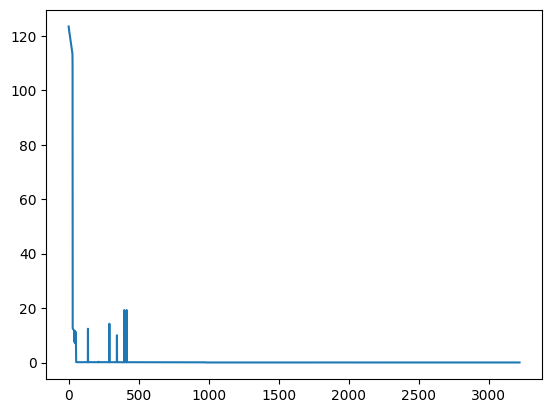

In [100]:
perceptron1layer.DrawTeachGraph()

In [101]:
perceptron= HebbNetworkGradient(neurons_count, perceptron1layer.BestBiasWeights, perceptron1layer.BestWeights)

1
2
3


C:\Users\Adminchik\AppData\Local\Temp\ipykernel_8332\919673897.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
C:\Users\Adminchik\AppData\Local\Temp\ipykernel_8332\4258121871.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return 1 / (1 + np.exp(-x.astype(np.float)))
C:\Users\Adminchik\AppData\Local\Temp\ipykernel_8332\4258121871.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details a

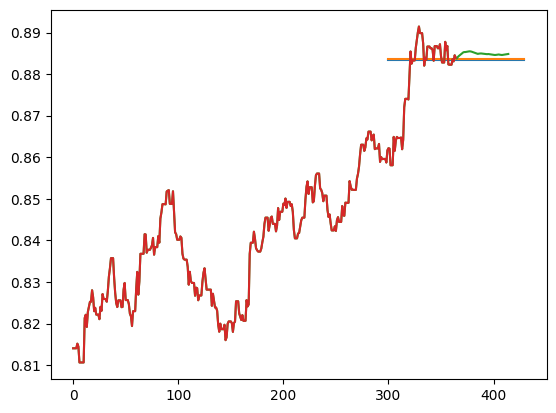

In [102]:

perc_y = perceptron.predict(test_x)
y_ela = el_net.predict(test_x)
win_y = slidingWindow(y, 50, 50)
win_x = np.arange(win_y.size)
plt.plot(test_x, perc_y)
plt.plot(test_x, y_ela)
plt.plot(win_x, win_y)
plt.plot(x, y)